
# TP — Modelos y Simulación (Premier League 2020–2023)



In [7]:

# Paso 2 — Limpieza y normalización a nivel partido
import pandas as pd
from pathlib import Path
from sim_utils import reconstruct_matches_level

RAW = Path(r"FILES/df_matches_limpio.xlsx")
df_raw = pd.read_excel(RAW)
clean = reconstruct_matches_level(df_raw)
CLEAN = Path(r"FILES/matches_clean.csv")
clean.to_csv(CLEAN, index=False)
clean.head(10)


,date,home,away,gh,ga,result,season,round
0,2019-08-09,Liverpool,Norwich City,4,1,H,2019/2020,1
1,2019-08-10,Bournemouth,Sheffield United,1,1,D,2019/2020,1
2,2019-08-10,Burnley,Southampton,3,0,H,2019/2020,1
3,2019-08-10,Crystal Palace,Everton,0,0,D,2019/2020,1
4,2019-08-10,Tottenham,Aston Villa,3,1,H,2019/2020,1
5,2019-08-10,Watford,Brighton,0,3,A,2019/2020,1
6,2019-08-10,West Ham,Manchester City,0,5,A,2019/2020,1
7,2019-08-11,Leicester City,Wolverhampton,0,0,D,2019/2020,1
8,2019-08-11,Manchester United,Chelsea,4,0,H,2019/2020,1
9,2019-08-11,Newcastle United,Arsenal,0,1,A,2019/2020,1


In [8]:

# Paso 3 — Partición estimación vs. validación (hold-out = última temporada)
import pandas as pd
from pathlib import Path
from sim_utils import split_est_val

CLEAN = Path(r"FILES/matches_clean.csv")
df_clean = pd.read_csv(CLEAN, parse_dates=["date"])
df_est, df_val, val_season = split_est_val(df_clean)
EST = Path(r"FILES/matches_est.csv")
VAL = Path(r"FILES/matches_val.csv")
df_est.to_csv(EST, index=False)
df_val.to_csv(VAL, index=False)
print("Hold-out (validación):", val_season)
df_est.head(10)


Hold-out (validación): 2023/2024


,date,home,away,gh,ga,result,season,round
0,2019-08-09,Liverpool,Norwich City,4,1,H,2019/2020,1
1,2019-08-10,Bournemouth,Sheffield United,1,1,D,2019/2020,1
2,2019-08-10,Burnley,Southampton,3,0,H,2019/2020,1
3,2019-08-10,Crystal Palace,Everton,0,0,D,2019/2020,1
4,2019-08-10,Tottenham,Aston Villa,3,1,H,2019/2020,1
5,2019-08-10,Watford,Brighton,0,3,A,2019/2020,1
6,2019-08-10,West Ham,Manchester City,0,5,A,2019/2020,1
7,2019-08-11,Leicester City,Wolverhampton,0,0,D,2019/2020,1
8,2019-08-11,Manchester United,Chelsea,4,0,H,2019/2020,1
9,2019-08-11,Newcastle United,Arsenal,0,1,A,2019/2020,1


In [9]:

# Paso 4–5 — Parámetros (Empírico y Poisson)
import pandas as pd
from pathlib import Path
from sim_utils import empirical_global, empirical_by_team, poisson_lambdas

EST = Path(r"FILES/matches_est.csv")
df_est = pd.read_csv(EST, parse_dates=["date"])

emp_global = empirical_global(df_est)
emp_global_path = Path(r"FILES/empirical_cdf_global.csv")
emp_global.to_csv(emp_global_path, index=False)

emp_team = empirical_by_team(df_est, min_n_home=35, min_n_away=35)
if len(emp_team):
    emp_team_path = Path(r"FILES/empirical_cdf_by_team.csv")
    emp_team.to_csv(emp_team_path, index=False)
    print("Guardado empírico por equipo:", emp_team_path)
else:
    print("No hay suficiente N para tablas empíricas por equipo. Se usará la global.")

lam = poisson_lambdas(df_est)
lam_path = Path(r"FILES/poisson_lambdas_by_team.csv")
lam.to_csv(lam_path, index=False)
lam.head(20)


Guardado empírico por equipo: FILES\empirical_cdf_by_team.csv


,team,lambda_home_for,n_home,lambda_away_for,n_away
0,Arsenal,1.947368,76,1.473684,76
1,Aston Villa,1.486842,76,1.131579,76
2,Bournemouth,1.105263,38,0.921053,38
3,Brentford,1.500000,38,1.289474,38
4,Brighton,1.289474,76,1.250000,76
5,Burnley,0.982456,57,0.947368,57
6,Chelsea,1.552632,76,1.618421,76
7,Crystal Palace,1.092105,76,1.039474,76
8,Everton,1.197368,76,1.013158,76
9,Fulham,1.052632,38,1.105263,38


In [10]:
# Paso 6 — Configuración experimental
from pathlib import Path
import pandas as pd
import sys
from importlib import reload

# Inputs
df_val = pd.read_csv(r"FILES/matches_val.csv", parse_dates=["date"])

# Parámetros de simulación
R = 1000      # cantidad de réplicas 
SEED = 123  # semilla aleatoria para reproducibilidad

In [11]:
# Paso 7A — Simulación Empírica (Transformada Inversa)
from sim_utils import simulate_season_empirical, summarize_points
emp_global = pd.read_csv(r"FILES/empirical_cdf_global.csv")
emp_team_path = r"FILES/empirical_cdf_by_team.csv"
emp_team = pd.read_csv(emp_team_path)

emp_points = simulate_season_empirical(
    df_fixture=df_val,
    emp_global=emp_global,
    emp_by_team=emp_team,
    R=R,
    seed=SEED
)
emp_summary = summarize_points(emp_points)

emp_points.to_csv(r"FILES/points_empirical_long.csv", index=False)
emp_summary.to_csv(r"FILES/points_empirical_summary.csv", index=False)
emp_summary.head(20)


,team,mean,std,p50,p90,p95,n_rep
12,Manchester City,70.065,7.462202,60.0,70.0,79.0,1.0
10,Liverpool,68.798,7.571164,59.0,69.0,79.0,1.0
13,Manchester United,60.591,7.715131,51.0,60.0,71.0,1.0
17,Tottenham,60.346,8.084531,50.0,60.0,71.0,1.0
0,Arsenal,60.282,8.086276,50.0,61.0,70.0,1.0
6,Chelsea,54.830,7.757401,45.0,55.0,65.0,1.0
3,Brentford,53.610,8.001370,44.0,53.0,64.0,1.0
15,Nottingham Forest,51.896,7.807698,42.0,52.0,62.0,1.0
14,Newcastle United,51.783,7.679771,42.0,52.0,62.0,1.0
11,Luton Town,51.737,8.404908,41.0,51.0,62.0,1.0


In [12]:
# Paso 7B — Simulación Poisson
from sim_utils import simulate_season_poisson, summarize_points
lambdas = pd.read_csv(r"FILES/poisson_lambdas_by_team.csv")

poi_points = simulate_season_poisson(
    df_fixture=df_val,
    lambdas=lambdas,
    R=R,
    seed=SEED
)
poi_summary = summarize_points(poi_points)

poi_points.to_csv(r"FILES/points_poisson_long.csv", index=False)
poi_summary.to_csv(r"FILES/points_poisson_summary.csv", index=False)
poi_summary.head(20)


,team,mean,std,p50,p90,p95,n_rep
12,Manchester City,78.336,7.348000,69.0,78.0,87.0,1.0
10,Liverpool,71.513,7.949656,61.0,72.0,82.0,1.0
17,Tottenham,63.543,8.182488,53.0,64.0,74.0,1.0
0,Arsenal,62.033,7.831810,52.0,62.0,72.0,1.0
13,Manchester United,61.380,7.917846,51.0,61.0,72.0,1.0
6,Chelsea,59.206,8.018095,48.0,59.0,70.0,1.0
18,West Ham,54.069,7.633775,44.0,54.0,64.0,1.0
3,Brentford,53.811,7.998453,43.0,54.0,64.0,1.0
1,Aston Villa,52.020,7.766848,42.0,52.0,62.0,1.0
11,Luton Town,51.228,7.896478,41.0,51.0,61.0,1.0


### Visualizaciones


In [13]:
mean_home = df_est["gh"].mean()
mean_away = df_est["ga"].mean()

tabla_91 = pd.DataFrame({
    "Condición": ["Local", "Visitante"],
    "Media de goles": [mean_home, mean_away]
})

tabla_91


,Condición,Media de goles
0,Local,1.503947
1,Visitante,1.267763


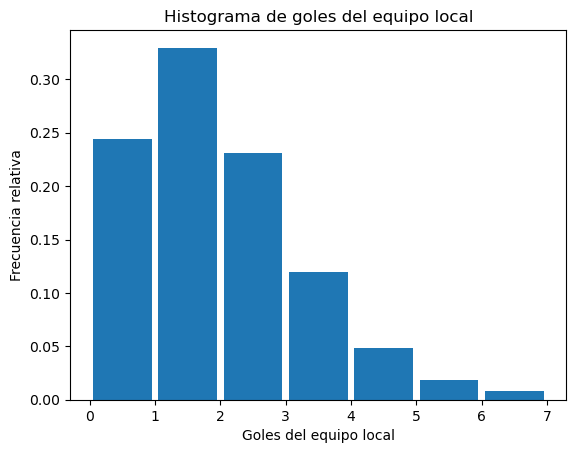

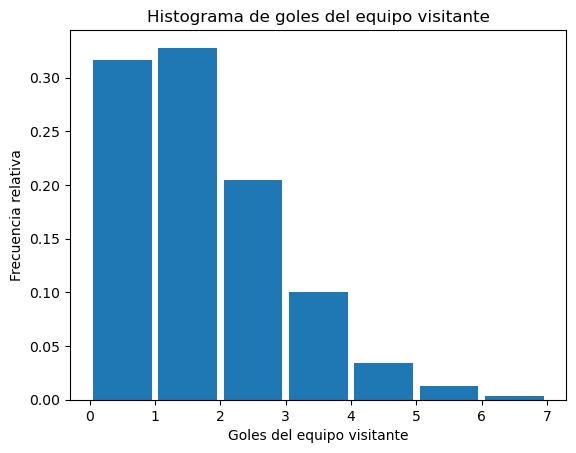

In [14]:
import matplotlib.pyplot as plt

# Histograma goles local
plt.figure()
df_est["gh"].plot(
    kind="hist",
    bins=range(0, 8),   # 0,1,2,...,7
    density=True,
    rwidth=0.9
)
plt.xlabel("Goles del equipo local")
plt.ylabel("Frecuencia relativa")
plt.title("Histograma de goles del equipo local")
plt.show()

# Histograma goles visitante
plt.figure()
df_est["ga"].plot(
    kind="hist",
    bins=range(0, 8),
    density=True,
    rwidth=0.9
)
plt.xlabel("Goles del equipo visitante")
plt.ylabel("Frecuencia relativa")
plt.title("Histograma de goles del equipo visitante")
plt.show()


In [15]:
# Asignar puntos a local y visitante
def assign_points(row):
    if row["gh"] > row["ga"]:
        return pd.Series({"points_home": 3, "points_away": 0})
    elif row["gh"] < row["ga"]:
        return pd.Series({"points_home": 0, "points_away": 3})
    else:
        return pd.Series({"points_home": 1, "points_away": 1})

df_points = df_est.copy()
df_points[["points_home", "points_away"]] = df_points.apply(assign_points, axis=1)

# Pasar a formato largo: una fila por (season, team)
home_long = (
    df_points[["season", "home", "points_home"]]
    .rename(columns={"home": "team", "points_home": "points"})
)
away_long = (
    df_points[["season", "away", "points_away"]]
    .rename(columns={"away": "team", "points_away": "points"})
)

points_by_team_season = (
    pd.concat([home_long, away_long], ignore_index=True)
    .groupby(["season", "team"], as_index=False)["points"].sum()
)

points_by_team_season.head()


,season,team,points
0,2019/2020,Arsenal,56
1,2019/2020,Aston Villa,35
2,2019/2020,Bournemouth,34
3,2019/2020,Brighton,41
4,2019/2020,Burnley,54


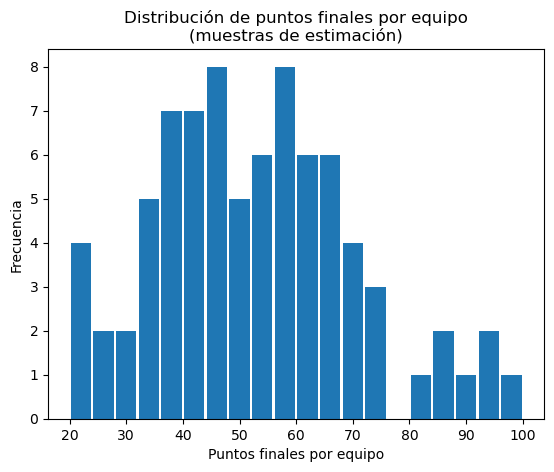

In [ ]:
plt.figure()
points_by_team_season["points"].plot(
    kind="hist",
    bins=range(20, 101, 4),  
    rwidth=0.9
)
plt.xlabel("Puntos finales por equipo")
plt.ylabel("Frecuencia")
plt.title("Distribución de puntos finales por equipo\n(muestras de estimación)")
plt.show()


In [17]:
import pandas as pd
from sim_utils import  split_est_val, poisson_lambdas


# Muestra de estimación (histórico) y validación (fixture objetivo)
df_est, df_val, val_season = split_est_val(clean)

lambdas = poisson_lambdas(df_est)


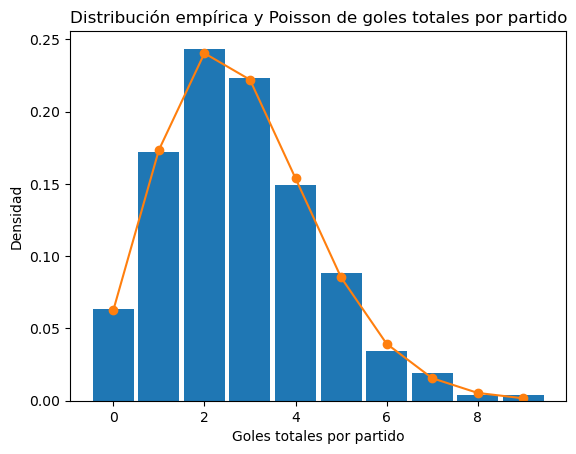

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Goles totales por partido en la muestra de estimación
goals_total = df_est["gh"] + df_est["ga"]

# Parámetro lambda estimado (media muestral)
lambda_tot = goals_total.mean()

# Soporte para la Poisson (0,1,...,max_goals)
max_goals = int(goals_total.max())
k_vals = np.arange(0, max_goals + 1)

# pmf de Poisson(k; lambda)
pmf = np.exp(-lambda_tot) * lambda_tot**k_vals / np.array([math.factorial(k) for k in k_vals])

plt.figure()
# Histograma empírico (densidad)
plt.hist(
    goals_total,
    bins=np.arange(-0.5, max_goals + 1.5, 1),
    density=True,
    rwidth=0.9
)

# Curva teórica de Poisson
plt.plot(k_vals, pmf, marker="o")

plt.xlabel("Goles totales por partido")
plt.ylabel("Densidad")
plt.title("Distribución empírica y Poisson de goles totales por partido")
plt.show()


In [ ]:
import numpy as np

def simulate_goals_fixture(df_fixture, lambdas, R=1000, seed=123):
    rng = np.random.default_rng(seed)

    # Diccionarios de lambda por equipo
    lam_h = {row["team"]: float(row["lambda_home_for"]) for _, row in lambdas.iterrows()}
    lam_a = {row["team"]: float(row["lambda_away_for"]) for _, row in lambdas.iterrows()}

    # Valores por defecto 
    default_home = np.nanmean(list(lam_h.values()))
    default_away = np.nanmean(list(lam_a.values()))

    goals_home_all = []
    goals_away_all = []

    for r in range(R):
        for _, row in df_fixture.iterrows():
            team_h = row["home"]
            team_a = row["away"]

            lambda_home = lam_h.get(team_h, default_home)
            lambda_away = lam_a.get(team_a, default_away)

            gh_sim = rng.poisson(lambda_home)
            ga_sim = rng.poisson(lambda_away)

            goals_home_all.append(gh_sim)
            goals_away_all.append(ga_sim)

    return np.array(goals_home_all), np.array(goals_away_all)

g_home_sim, g_away_sim = simulate_goals_fixture(df_val, lambdas, R=1000, seed=123)

# Medias históricas en la temporada de validación
mean_home_hist = df_val["gh"].mean()
mean_away_hist = df_val["ga"].mean()

# Medias simuladas (promedio sobre todas las réplicas y partidos)
mean_home_sim = g_home_sim.mean()
mean_away_sim = g_away_sim.mean()

import pandas as pd

tabla_92 = pd.DataFrame({
    "Condición": ["Local", "Visitante"],
    "Media histórica": [mean_home_hist, mean_away_hist],
    "Media simulada": [mean_home_sim, mean_away_sim]
})

tabla_92


,Condición,Media histórica,Media simulada
0,Local,1.800000,1.508297
1,Visitante,1.478947,1.225163


In [20]:
from sim_utils import simulate_season_poisson
# df_val: temporada de validación (fixture)
# lambdas: tabla con λ_home_for y λ_away_for

R = 1000
points_sim = simulate_season_poisson(
    df_fixture=df_val,
    lambdas=lambdas,
    R=R,
    seed=123
)
# points_sim tiene columnas: replica, team, points


In [21]:
import pandas as pd

summary_93 = (
    points_sim
    .groupby("team")["points"]
    .agg(
        mean_points="mean",
        sd_points="std",
        p10=lambda s: s.quantile(0.10),
        p50="median",
        p90=lambda s: s.quantile(0.90),
    )
    .reset_index()
    .sort_values("mean_points", ascending=False)
)

summary_93.head(20)


,team,mean_points,sd_points,p10,p50,p90
12,Manchester City,78.336,7.348000,69.0,78.0,87.0
10,Liverpool,71.513,7.949656,61.0,72.0,82.0
17,Tottenham,63.543,8.182488,53.0,64.0,74.0
0,Arsenal,62.033,7.831810,52.0,62.0,72.0
13,Manchester United,61.380,7.917846,51.0,61.0,72.0
6,Chelsea,59.206,8.018095,48.0,59.0,70.0
18,West Ham,54.069,7.633775,44.0,54.0,64.0
3,Brentford,53.811,7.998453,43.0,54.0,64.0
1,Aston Villa,52.020,7.766848,42.0,52.0,62.0
11,Luton Town,51.228,7.896478,41.0,51.0,61.0


<Figure size 1000x600 with 0 Axes>

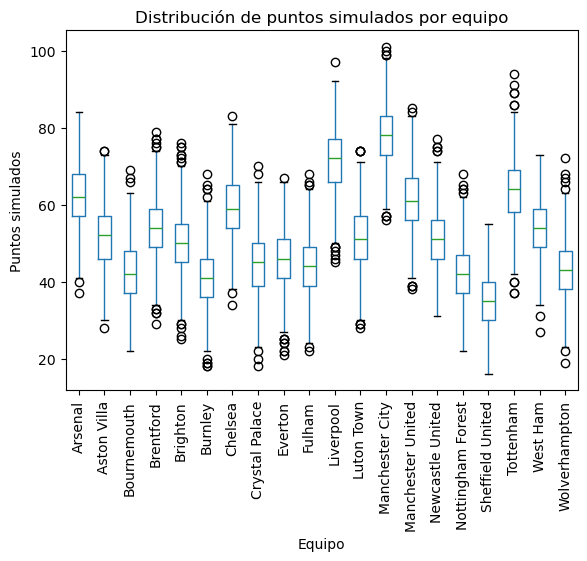

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
points_sim.boxplot(
    column="points",
    by="team",
    grid=False,
)
plt.xticks(rotation=90)
plt.xlabel("Equipo")
plt.ylabel("Puntos simulados")
plt.title("Distribución de puntos simulados por equipo")
plt.suptitle("")  
plt.show()


In [23]:
threshold = 70  

prob_over_thr = (
    points_sim
    .groupby("team")["points"]
    .apply(lambda s: (s >= threshold).mean())
    .reset_index(name=f"prob_points_ge_{threshold}")
    .sort_values(f"prob_points_ge_{threshold}", ascending=False)
)

prob_over_thr.head()


,team,prob_points_ge_70
12,Manchester City,0.885
10,Liverpool,0.608
17,Tottenham,0.222
0,Arsenal,0.164
13,Manchester United,0.153


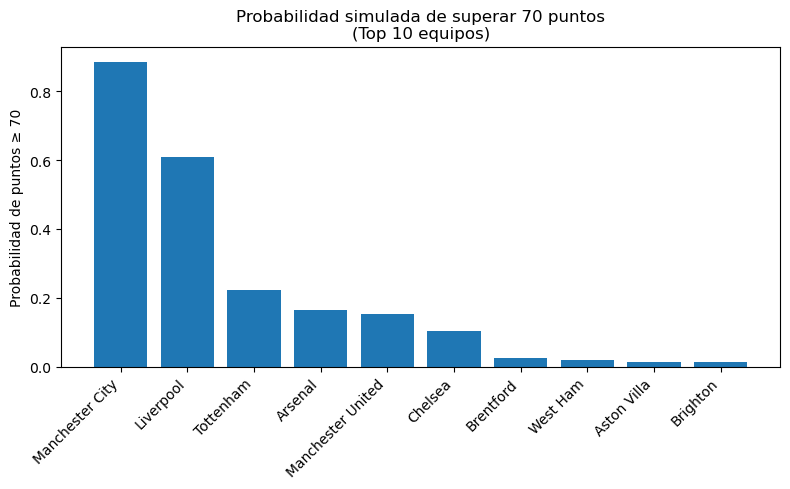

In [24]:
# Por ejemplo, top 10 en probabilidad de superar el umbral
top_prob = prob_over_thr.head(10)

plt.figure(figsize=(8, 5))
plt.bar(top_prob["team"], top_prob[f"prob_points_ge_{threshold}"])
plt.xticks(rotation=45, ha="right")
plt.ylabel(f"Probabilidad de puntos ≥ {threshold}")
plt.title(f"Probabilidad simulada de superar {threshold} puntos\n(Top 10 equipos)")
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd

# df_val: temporada de validación, con columnas gh, ga, home, away, season

def assign_points(row):
    if row["gh"] > row["ga"]:
        return pd.Series({"points_home": 3, "points_away": 0})
    elif row["gh"] < row["ga"]:
        return pd.Series({"points_home": 0, "points_away": 3})
    else:
        return pd.Series({"points_home": 1, "points_away": 1})

df_val_points = df_val.copy()
df_val_points[["points_home", "points_away"]] = df_val_points.apply(assign_points, axis=1)

home_val = (
    df_val_points[["home", "points_home"]]
    .rename(columns={"home": "team", "points_home": "points"})
)
away_val = (
    df_val_points[["away", "points_away"]]
    .rename(columns={"away": "team", "points_away": "points"})
)

points_real = (
    pd.concat([home_val, away_val], ignore_index=True)
    .groupby("team", as_index=False)["points"].sum()
    .rename(columns={"points": "points_real"})
)

points_real.head()


,team,points_real
0,Arsenal,89
1,Aston Villa,68
2,Bournemouth,48
3,Brentford,39
4,Brighton,48


In [26]:
# summary_93: team, mean_points, sd_points, p10, p50, p90

comp_real_sim = summary_93.merge(points_real, on="team", how="left")
comp_real_sim.head()


,team,mean_points,sd_points,p10,p50,p90,points_real
0,Manchester City,78.336,7.348000,69.0,78.0,87.0,91
1,Liverpool,71.513,7.949656,61.0,72.0,82.0,82
2,Tottenham,63.543,8.182488,53.0,64.0,74.0,66
3,Arsenal,62.033,7.831810,52.0,62.0,72.0,89
4,Manchester United,61.380,7.917846,51.0,61.0,72.0,60


<Figure size 1000x600 with 0 Axes>

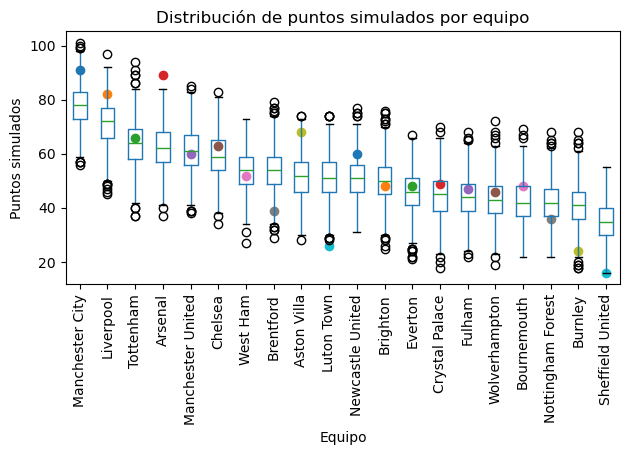

In [ ]:
import matplotlib.pyplot as plt

# Orden de equipos por puntos medios simulados
order_teams = (
    summary_93
    .sort_values("mean_points", ascending=False)["team"]
    .tolist()
)

# Aseguramos el orden en el DataFrame
points_sim_ord = points_sim.copy()
points_sim_ord["team"] = pd.Categorical(points_sim_ord["team"], categories=order_teams, ordered=True)

plt.figure(figsize=(10, 6))
ax = points_sim_ord.boxplot(column="points", by="team", grid=False)
plt.xticks(rotation=90)
plt.xlabel("Equipo")
plt.ylabel("Puntos simulados")
plt.title("Distribución de puntos simulados por equipo")
plt.suptitle("")


for i, team in enumerate(order_teams, start=1):
    pr = points_real.loc[points_real["team"] == team, "points_real"].values
    if len(pr) > 0:
        ax.scatter(i, pr[0])

plt.tight_layout()
plt.show()


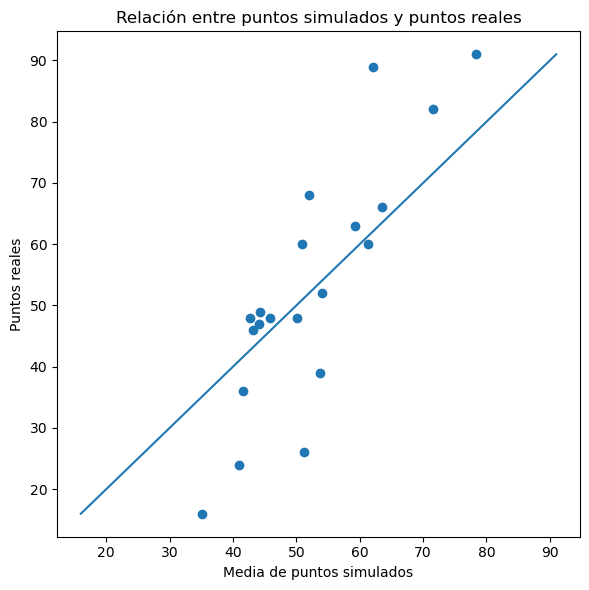

In [ ]:
plt.figure(figsize=(6, 6))

plt.scatter(comp_real_sim["mean_points"], comp_real_sim["points_real"])

plt.xlabel("Media de puntos simulados")
plt.ylabel("Puntos reales")
plt.title("Relación entre puntos simulados y puntos reales")

#  y = x como referencia
min_val = min(comp_real_sim["mean_points"].min(), comp_real_sim["points_real"].min())
max_val = max(comp_real_sim["mean_points"].max(), comp_real_sim["points_real"].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.tight_layout()
plt.show()


In [29]:
R = 1000
seeds = [123, 42, 2025]
summaries = []

for sd in seeds:
    pts_sim = simulate_season_poisson(df_fixture=df_val, lambdas=lambdas, R=R, seed=sd)
    summ = (
        pts_sim.groupby("team")["points"]
        .agg(mean_points="mean")
        .reset_index()
        .assign(seed=sd)
    )
    summaries.append(summ)

summary_seeds = pd.concat(summaries, ignore_index=True)


In [30]:
summary_seeds

,team,mean_points,seed
0,Arsenal,62.033,123
1,Aston Villa,52.020,123
2,Bournemouth,42.614,123
3,Brentford,53.811,123
4,Brighton,50.077,123
5,Burnley,40.925,123
6,Chelsea,59.206,123
7,Crystal Palace,44.338,123
8,Everton,45.879,123
9,Fulham,44.182,123
